# Segmentation
Image segmentation segment different image pixels by identifying them with different color

While in segmentation mask generation user can perform what is called mask prompting by guidling the model on the object of interest in order to predict the segmentation mask of that object. This is different from classic image segmentation as labels won't be provide for the output

In [ ]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

In [ ]:
#suppress error message
from transformers.utils import logging
logging.set_verbosity_error()

In [ ]:
#import needed libraries
from transformers import pipeline
from PIL import Image
from helper_2 import show_pipe_masks_on_image

In [ ]:
sam_pipeline = pipeline(task = 'mask-generation', model='Zigeng/SlimSAM-uniform-77')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

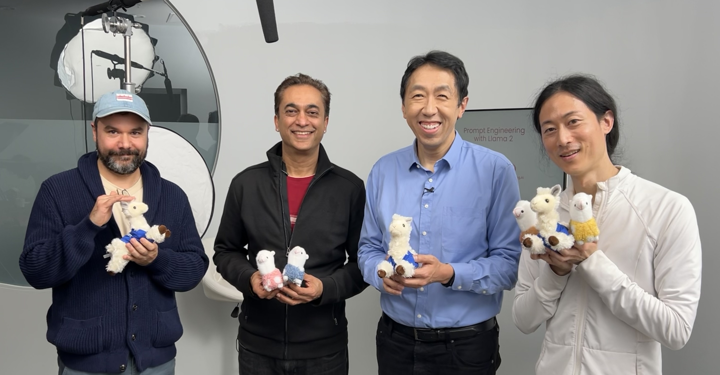

In [ ]:
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

In [ ]:
#The higher the value of 'points_per_batch', the more efficient pipeline inference will be
output = sam_pipeline(raw_image, points_per_batch = 32)

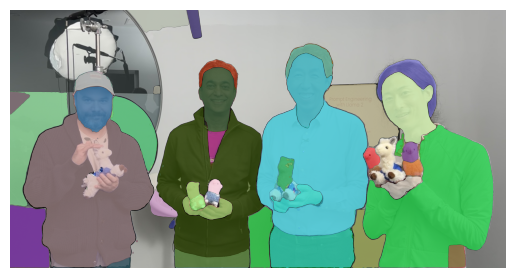

In [ ]:
#use the helper_2 method to visualize the mask segmented image
show_pipe_masks_on_image(raw_image, output)

# Faster Inference: Infer an Image and a Single Point

In [ ]:
#to get a better result let's use the model class itself from transformeers

from transformers import SamModel, SamProcessor


In [ ]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

In [ ]:
#print out model to see its architecture
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=168, out_features=504, bias=True)
          (proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=168, out_features=696, bias=True)
          (lin2): Linear(in_features=696, out_features=168, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(168, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
      (c

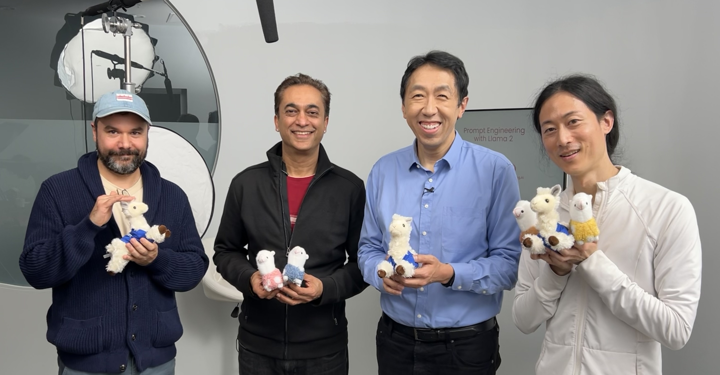

In [ ]:
raw_image.resize((720, 375))

In [ ]:
# Segment the blue shirt Andrew is wearing.
# Give any single 2D point that would be in that region (blue shirt).
input_points = [[[1600, 700]]]

In [ ]:
# Create the input using the image and the single point.
# return_tensors="pt" means to return PyTorch Tensors.
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [ ]:
#Given the inputs, get the output from the model.
import torch

with torch.no_grad():
  outputs = model(**inputs)

In [ ]:
#call the post_process_masks to get the predicted mask
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [ ]:
# Length of predicted_masks corresponds to the number of images that are used in the input.
len(predicted_masks)

1

In [ ]:
# Inspect the size of the first ([0]) predicted mask
predicted_mask = predicted_masks[0]

In [ ]:
#predicted score
outputs.iou_scores

tensor([[[0.9583, 0.9551, 0.9580]]])

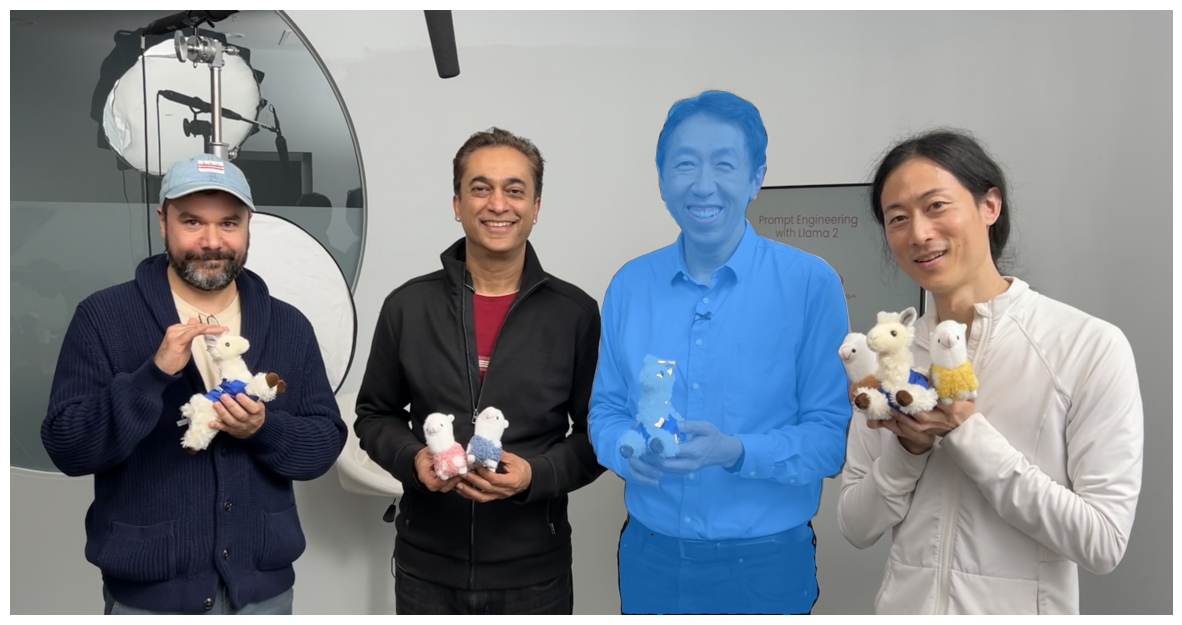

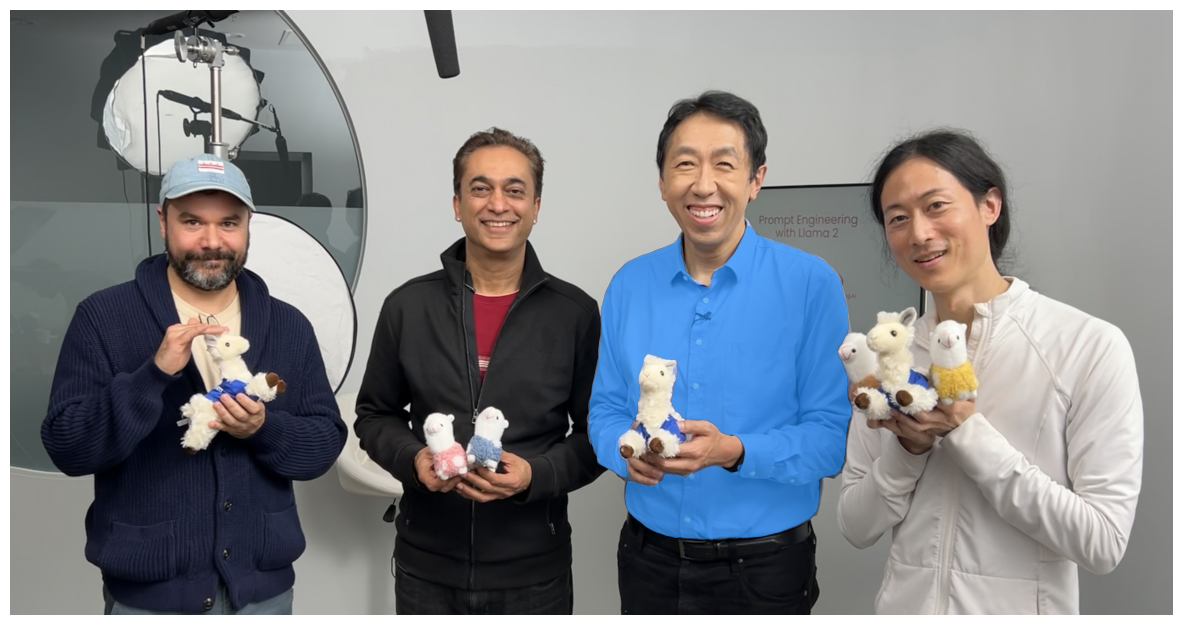

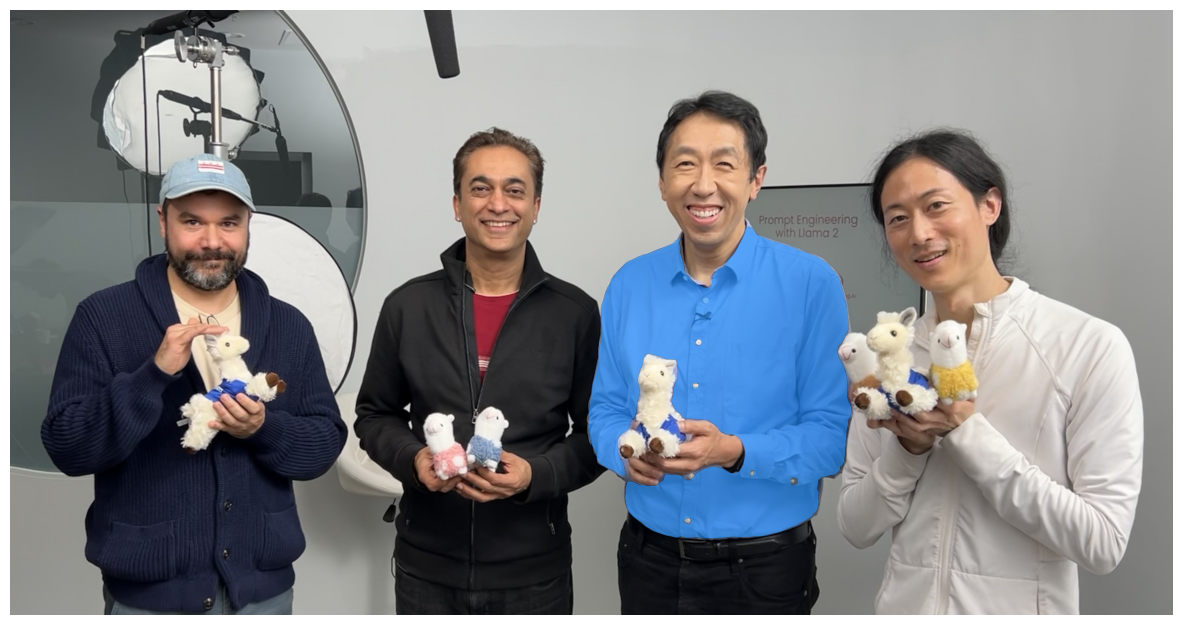

In [ ]:
#print all the predicted segmentation mask
from helper_2 import show_mask_on_image
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

#Depth Estimation with DPT

This is model that can be used to perform depth estimation given an image

In [ ]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

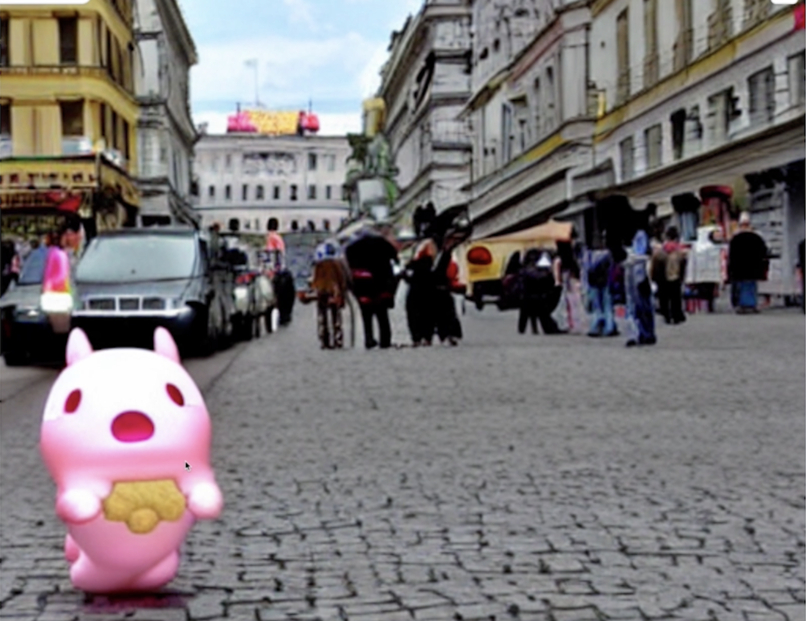

In [ ]:
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

In [ ]:
#estimate the depth of this image
output = depth_estimator(raw_image)

In [ ]:
# Post-process the output image to resize it to the size of the original image.
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [ ]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [ ]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [ ]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [ ]:
raw_image.size[::-1],

((1242, 1612),)

In [ ]:
prediction

tensor([[[[ 248.1578,  248.2615,  248.7577,  ...,  468.0627,  447.0034,
            442.8551],
          [ 248.0309,  248.1445,  248.6919,  ...,  477.7614,  458.3928,
            454.5768],
          [ 247.0836,  247.2387,  247.9993,  ...,  508.8534,  494.9499,
            492.2081],
          ...,
          [3040.0398, 3040.3997, 3042.2336,  ..., 3285.1299, 3283.1477,
           3282.7585],
          [3037.8718, 3038.3882, 3041.0300,  ..., 3288.0659, 3286.3369,
           3285.9924],
          [3037.5525, 3038.1152, 3040.9968,  ..., 3289.0708, 3287.3918,
           3287.0559]]]])

In [ ]:
# Normalize the predicted tensors (between 0 and 255) so that they can be displayed.
import numpy as np
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

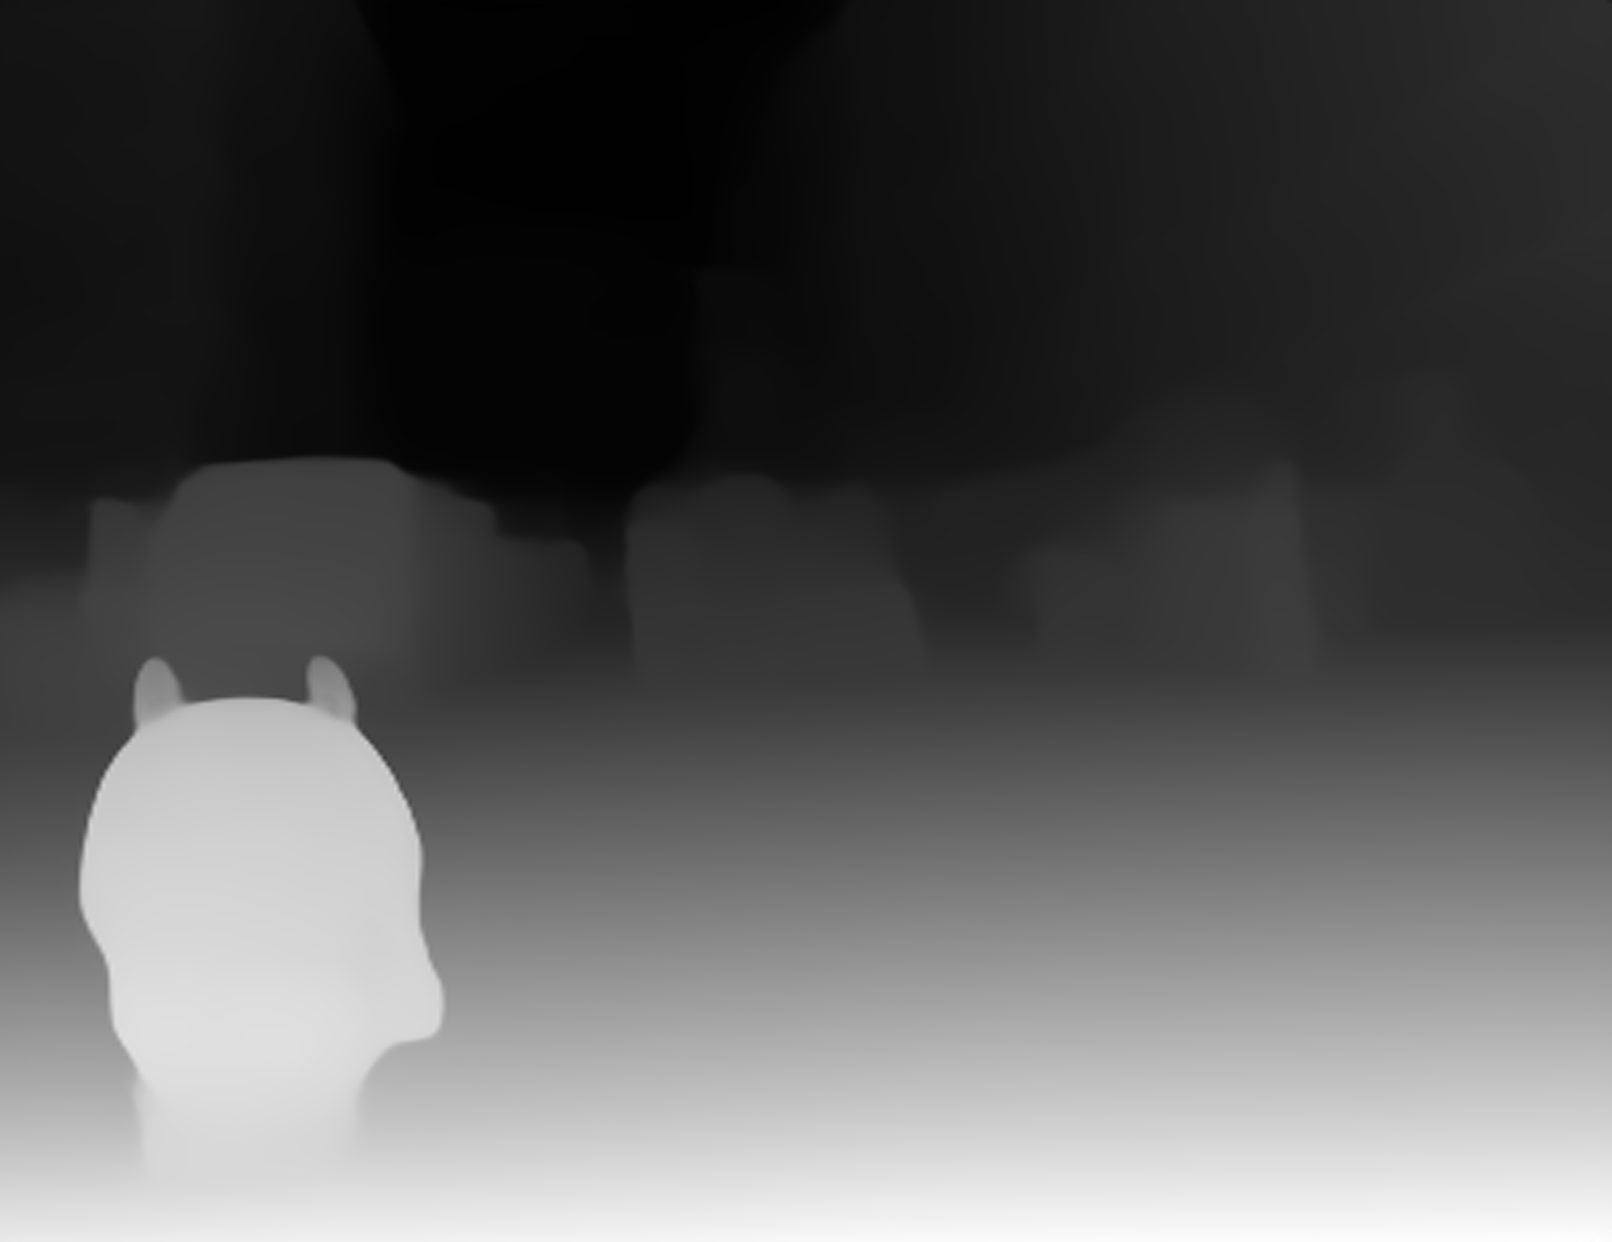

In [ ]:
depth

In [ ]:
import gradio as gr
from transformers import pipeline

In [ ]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [ ]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

In [ ]:
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eae096a4a676141b9b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
iface.close()

Closing server running on port: 7860
